<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Jen_Banks__LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
#imports

%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [0]:
# Data Wranggling

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 6.1% of 'funder' cell are missing, fill with mode
    X['funder']=X['funder'].fillna(X.funder.mode()[0], inplace=False)

    # About 6.2% of 'installer' cell are missing, fill with mode
    X['installer']=X['installer'].fillna(X['installer'].mode()[0], inplace=False)

    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

     # About 5.7% of 'public_meeting' cell are missing, fill with mode
    X['public_meeting']=X['public_meeting'].fillna(X['public_meeting'].mode()[0],
                                                   inplace=False)

    # About 6.5% of 'public_meeting' cell are missing, fill with mode
    X['scheme_management']=X['scheme_management'].fillna(X['scheme_management'].mode()[0],
                                                         inplace=False)
    
    # About 5.2% of 'public_meeting' cell are missing, fill with mode
    X['permit']=X['permit'].fillna(X['permit'].mode()[0], inplace=False)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [34]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8105585736174955


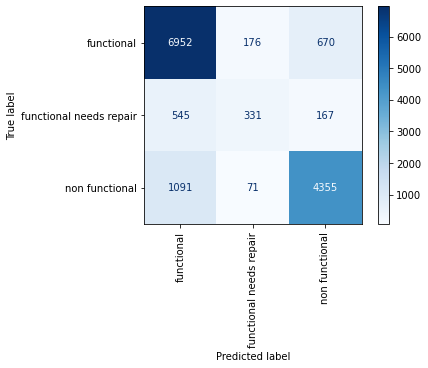

In [35]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, 
                      X_val,y_val,
                      values_format='.0f',
                      xticks_rotation='vertical',
                      cmap='Blues');

In [36]:
# Number of correct predictions

6952+331+4355

11638

In [37]:
#Total predictions

len(y_val)

14358

In [38]:
#Accuracy

11638/len(y_val)

0.8105585736174955

In [39]:
# Classification report

from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      7798
functional needs repair       0.57      0.32      0.41      1043
         non functional       0.84      0.79      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.67      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



In [40]:
!pip install scikit-plot

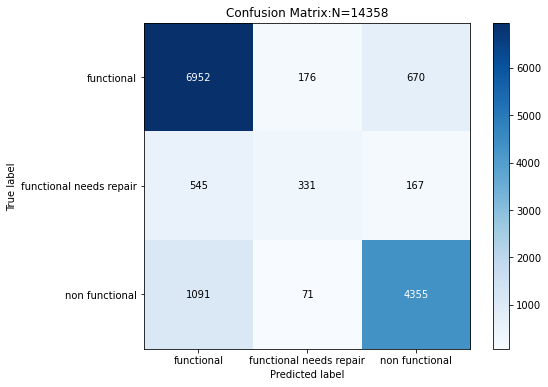

In [41]:
from scikitplot.metrics import  plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
                      figsize=(8,6),
                      title=f'Confusion Matrix:N={len(y_val)}',
                      normalize=False
);

##Precision Example Computation

In [42]:
#How many correct predictions of non functional?
4335

#How many total predictions of non functional??
tot_non_funct= 4335 + 167 + 670

# Precision for non functional

4335/tot_non_funct

0.8381670533642691

##Recall Example Computation

In [43]:
# How many actual non functional?

tot_tru_nf= 1091+71+4335

#Recall for non functional
4335/tot_tru_nf

0.7886119701655449

In [44]:
#Try anothe pipeline
# Using Bagging ensemble, no replacement
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

pipeline_bag1=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),    
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=100,
                      max_features=0.6, 
                      max_samples=0.4, 
                      bootstrap=False, 
                      bootstrap_features= False)
)

feat =[ 0.3, .5, 0.8]
train_scores, val_scores=validation_curve(
    pipeline_bag1, X_train,y_train,
    param_name='baggingclassifier__max_features',
    param_range=feat, scoring='accuracy',
    cv= 3,
    n_jobs=-1
)

pipeline_bag1.fit(X_train, y_train)
print(pipeline_bag1.score(X_train, y_train))
print(pipeline_bag1.score(X_val, y_val))

0.9671861817858888
0.8108371639504109


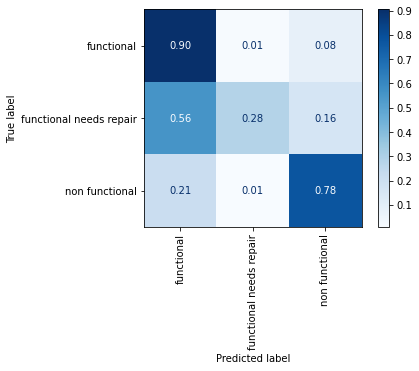

In [45]:
#Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline_bag1, 
                      X_val,y_val,
                      values_format='.2f',
                      xticks_rotation='vertical',
                      cmap='Blues',
                      normalize= 'true'
);


In [46]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      7798
functional needs repair       0.57      0.32      0.41      1043
         non functional       0.84      0.79      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.67      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



In [53]:
# Checking the percentages of each predictions

y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [54]:
#Grouping 'funtional but needs repair' and 'non functional' together

y_train=y_train !='functional'
y_val=y_val !='functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [55]:
len(val)==len(test)

True

In [0]:
# Retraining the dataset using the new grouping

pipeline_bag1.fit(X_train, y_train)
y_pred=pipeline_bag1.predict(X_val)

In [58]:
# Determining the probablities for TRUE(needs repair or nonfunctional)

y_pred_prob_pipeline_bag1= pipeline_bag1.predict_proba(X_val)[:,1]
y_pred_prob_pipeline_bag1

array([0.99 , 0.82 , 0.1  , ..., 0.15 , 0.51 , 0.045])

In [65]:
import seaborn as sns
from ipywidgets import interact, fixed

y_pred_prob_pipeline_bag1=pipeline_bag1.predict_proba(X_val)[:,1]

def set_threshold(y_true, y_pred_prob_pipeline_bag1, threshold=0.5):
  y_pred=y_pred_prob_pipeline_bag1 > threshold

  ax= sns.distplot(y_pred_prob_pipeline_bag1);
  ax.axvline(threshold, color='red');
  plt.show();

  print (classification_report(y_true, y_pred))
  print(pd.Series(y_pred).value_counts())

interact(set_threshold,
         y_true=fixed(y_val),
         y_pred_prob_pipeline_bag1=fixed(y_pred_prob_pipeline_bag1),
         threshold=(0, 1, 0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.set_threshold>

In [66]:
# Identify the 2000 waterpumps with highest predicted probabilities

results = pd.DataFrame({'y_val':y_val, 'y_pred_prob': y_pred_prob_pipeline_bag1})
results

,y_val,y_pred_prob
58046,True,0.990
41184,True,0.820
27587,False,0.100
53109,False,0.030
7245,True,0.590
...,...,...
18760,False,0.730
36059,True,0.780
4759,False,0.150
43621,False,0.510


In [69]:
top2000=results.sort_values(by='y_pred_prob', ascending=False)[:2000]
top2000

,y_val,y_pred_prob
26882,True,1.00
23969,True,1.00
39671,True,1.00
10043,True,1.00
8834,True,1.00
...,...,...
34769,True,0.88
30523,True,0.88
36653,True,0.88
20972,True,0.88


In [70]:
# How many of our recommendations were relevant?

trips = 2000
print(f'Baseline: {trips*.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model:Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model:Predict 1970 waterpump repairs in 2000 trips


In [71]:
# Computing precision on the top 2000 waterpumps

precision_at_k2000= relevant_recommendations/trips
precision_at_k2000

0.985

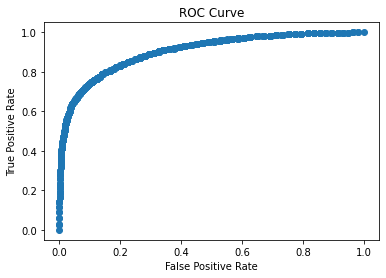

In [77]:
#ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_pipeline_bag1)

plt.scatter(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate");

In [78]:
# Area under the curve

from sklearn.metrics import  roc_auc_score
roc_auc_score(y_val, y_pred_prob_pipeline_bag1)

0.9038100568313326

In [75]:
#Tabulating the results

pd.DataFrame({'False Positive Rate':fpr,
              'True Positive Rate': tpr,
              'Threshold':thresholds}
)

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.000128,0.027134,1.000000
2,0.000128,0.027439,0.998889
3,0.000385,0.060061,0.990000
4,0.000385,0.060213,0.986667
...,...,...,...
815,0.965376,0.999085,0.015000
816,0.965632,0.999085,0.012500
817,0.980764,0.999543,0.010000
818,0.980893,0.999543,0.004000
